In [1]:
import json
import logging
import sys
import pandas as pd
import numpy as np
import cvxportfolio as cp
from cmr.universe import build_universe
from cmr.data_loader import load_features, load_market_data, load_ret
from cmr.returns import TaReturnsForecast
from cmr.strategy import CryptoStatArb
from cmr.risk import ReturnsCovRiskModel

import matplotlib.pyplot as plt
%matplotlib inline

## Define scope
* time interval : 2020 Jan to 2022 Jan <br>
* crypto symbol: average daily volume 200k USD

In [4]:
start = pd.Timestamp(2020, 1, 1)
end = pd.Timestamp(2022, 1, 31)
cfg = json.load(open("cfg/JW_CRYPTO.json"))
symbols = sorted(build_universe(cfg["symbol_pattern"], start, end, adv_limit=cfg["adv_limit"]))
print(cfg)
print(symbols)

{'portfolio_id': 'JW_CRYPTO', 'adv_limit': 200000.0, 'symbol_pattern': '*usd', 'lambda_risk': 1.0, 'half_spread': 0.005, 'borrow_costs': 0, 'opt_kwargs': {'leverage_limit': 1, 'max_weights': 0.1, 'min_weights': -0.1}, 'resample_rule': '1H'}
['adausd', 'atousd', 'bsvusd', 'btcusd', 'bttusd', 'dotusd', 'dshusd', 'eosusd', 'etcusd', 'ethusd', 'filusd', 'ftmusd', 'iotusd', 'ltcusd', 'neousd', 'omgusd', 'solusd', 'trxusd', 'udcusd', 'uniusd', 'uosusd', 'ustusd', 'xlmusd', 'xmrusd', 'xrpusd', 'xtzusd', 'yfiusd', 'zecusd']


## Features

<i> Technical Analysis Module </i>: uses financial time series datasets (open, close, high, low, volume), for feature engineering. <br>
<i> https://technical-analysis-library-in-python.readthedocs.io/en/latest/ </i><br>
* Momentum Indicators
* Volume Indicators
* Volatility Indicators
* Trend Indicators
* Others Indicators

In [5]:
feat = load_features(symbols, start, end)

PicklingError: Could not pickle the task to send it to the workers.

## Data preprocessing

* Train & Test (& Validation data) split
* Feature standardization
* PCA for dimensionality reduction
* Symbol - one hot encoder
* Format to time series generators

## Prediction model

### Model selection
Literature on crypto currencies, mostly leveraging LSTM:
* Bitcoin Transaction Strategy Construction Based on Deep Reinforcement Learning
<i> https://arxiv.org/abs/2109.14789 </i>
* On Technical Trading and Social Media Indicators in Cryptocurrencies' Price Classification Through Deep Learning
<i> https://arxiv.org/abs/2102.08189 </i>

### Hyperparameter tuning

| Item |  |  |  |
| --- | --- | --- | --- |
| Look Back Hours| 3 | 24 | 72 |
| Batch Size | 32 | 64 | 128 |
| Loss | MSE | MAE | |
| Hidden Layers | 1 | 2 | |
| Hidden Units | 32 | 64 | |
| Hidden Activation | tanh | relu | |
| Output Activation | tanh | linear | |


Adam Optimization : dynamically adjust the learning rate of each parameter. <br>
Train / Test / Validation split. <br>
Drop out rate 0.2 <br>
Early stop with patience 2 <r>



##  Portfolio optimization and simulation

<i> cvxportfolio module </i> : portfolio optimization and simulation, based on the paper Multi-Period Trading via Convex Optimization.
<i> https://github.com/cvxgrp/cvxportfolio </i> <br>
<i> https://web.stanford.edu/~boyd/papers/cvx_portfolio.html </i> <br>

### Optimizer
* Single forecast period optimization, mean-variance portfolio optimization
* Costs : risk model, transaction cost model ( and carry cost model)
* Starts with 100k cash holding, hourly rebalance

### Constraints
* Dollar neutral
* Leverage limit 1
* Maximum holding weight 0.1
* Minimum holding weight -0.1

### Risk model
* Standard deviation risk model


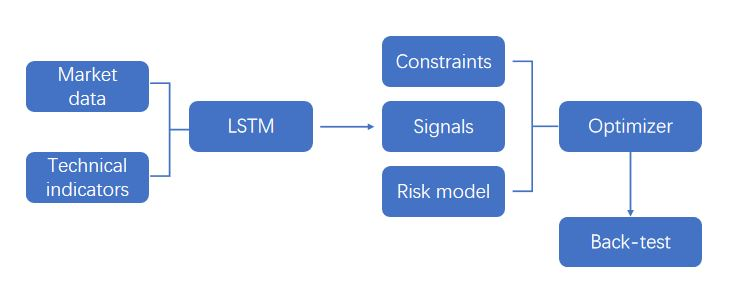

In [ ]:
# build costs
risk_model = ReturnsCovRiskModel(return_forecast.returns.columns[:-1], start, end).get_value()
tcost_model = cp.TcostModel(half_spread=0.0025)  # different by market, or even more complex by ticker
# bcost_model = cp.HcostModel(borrow_costs=borrow_costs / 250)  # borrow costs by ticker can be read from broker
costs = [10 * cp.FullSigma(risk_model), ]  # fit into cp format

# build strategy
optimizer = CryptoStatArb(return_forecast, costs, **cfg['opt_kwargs'])

# back-test
returns = load_ret(return_forecast.returns.columns[:-1], start, end).fillna(0)
market_sim = cp.MarketSimulator(returns, [], cash_key='cash')
initial_portfolio = pd.Series(index=returns.columns, data=0)
initial_portfolio.loc['cash'] = 1e5
result = market_sim.run_backtest(initial_portfolio, signals.index[0], signals.index[-1], policy=optimizer)

# performance analytics
result.summary()